### Import

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import shapefile
import re
import pickle
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as polygon
from matplotlib.collections import PatchCollection as patchCollection
from tqdm import tqdm
from collections import Counter
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist

### Borough Codes

In [2]:
B = {}
B['manhattan'] = 1
B['thebronx'] = 2
B['brooklyn'] = 3
B['queens'] = 4
B['statenisland'] = 5

### Load Graphs

In [3]:
A = []
A.append({})
A.append(pickle.load(open("../data/graphs/nyc_manhattan.p","rb")))
A.append(pickle.load(open("../data/graphs/nyc_thebronx.p","rb")))
A.append(pickle.load(open("../data/graphs/nyc_brooklyn.p","rb")))
A.append(pickle.load(open("../data/graphs/nyc_queens.p","rb")))
A.append(pickle.load(open("../data/graphs/nyc_statenisland.p","rb")))

### Extract Info Helper Function

In [4]:
def extractInfo(borough,A,B):
    
    #Extract
    index = B[borough]
    X = A[index]
    G = X['G']
    O = X['O']
    N = X['N']
    streets = X['streets']
    coordsdf = X['coordsdf']
    edges = X['edges']
    nodes = X['nodes']
    nodenames = X['nodenames']

    #Restrict
    streets = streets[['borocode', 'id', 'orig_id',\
                       'l_high_hn', 'l_low_hn', 'l_zip',\
                       'r_high_hn', 'r_low_hn', 'r_zip',\
                       'shape_leng', 'st_label', 'trafdir',\
                       'slng', 'slat', 'elng', 'elat',\
                       'sendpoint','eendpoint','endpoint']]

    #Return
    return G,O,N,streets,coordsdf,edges,nodes,nodenames

### Add Borough to Node Names Helper Function

In [5]:
def addBoroughNameToNodes(nodes,nodenames,edges,borough):
    
    #Add Borough to nodes
    newnodes = []
    newnames = []
    newedgenames = []
    for n,node in enumerate(nodes):
        newnode = {}
        for item in node:
            newitem = str(item) + '-' + borough
            newnode[newitem] = node[item]
        newname = nodenames[n] + ' | ' + borough.upper()
        newnames.append(newname)
        newnodes.append(newnode)
    
    #Add Borough Name
    for i in range(len(edges)):
        node1,node2,length = edges[i]
        node1 = node1 + ' | ' + borough.upper()
        node2 = node2 + ' | ' + borough.upper() 
        edges[i] = (node1,node2,length)

    #Return
    return newnodes,newnames,newedgenames

### Get Borough Data

In [6]:
Bdata = {}
boroughs = list(B.keys())
for borough in boroughs:
    G,O,N,streets,coordsdf,edges,nodes,nodena = extractInfo(borough,A,B)
    Bdata[borough] = (G,O,N,streets,coordsdf,edges,nodes,nodena)

### Find indices of streets that are not fully connected

In [7]:
for borough in boroughs:
    (G,O,N,streets,coordsdf,edges,nodes,nodena) = Bdata[borough]
    s1 = streets[streets['sendpoint'] > 0.0]
    e1 = streets[streets['eendpoint'] > 0.0]
    cstreets = pd.concat((s1,e1),axis=0)
    slnglat = cstreets[['slng','slat']].values
    elnglat = cstreets[['elng','elat']].values
    Bdata[borough] = (G,O,N,streets,coordsdf,edges,nodes,nodena,cstreets,slnglat,elnglat)

### Connection Node Creator

In [8]:
def connectionNodeCreator(pos1,pos2,type1,type2,streets1,streets2,borough1,borough2):

    #Create New Connection Nodes
    nodenames = []
    nodes = []
    for i in range(len(pos1)):
        i1 = pos1[i]
        i2 = pos2[i]
        index1 = streets1.iloc[i1].id
        index2 = streets2.iloc[i2].id
        name1 = streets1.iloc[i1].st_label.upper()
        name2 = streets2.iloc[i2].st_label.upper()
        lng = streets1.iloc[i1].elng
        lat = streets1.iloc[i1].elat
        nodename = name1 + ' | ' + name2 + ' | ' + str(lng) + ' | ' + str(lat) + ' | ' + borough1.upper() + ' <-> ' + borough2.upper()
        index1 = str(index1) + '-' + borough1
        index2 = str(index2) + '-' + borough2
        node = {index1:type1,index2:type2}    
        nodenames.append(nodename)
        nodes.append(node)        

    #Return
    return nodes,nodenames

### Add Borough and height to Node Names

In [9]:
newedges = []
newnodes = []
newnodenames = []
for borough in boroughs:
    (G,O,N,streets,coordsdf,edges,nodes,nodena,cstreets,slnglat,elnglat) = Bdata[borough]
    newnodes_tmp,newnodenames_tmp, edgenames_tmp = addBoroughNameToNodes(nodes,nodena,edges,borough)
    newedges = newedges + edges
    newnodes = newnodes + newnodes_tmp
    newnodenames = newnodenames + newnodenames_tmp

### Compute Distance Matrices and create Nodes

In [10]:
mindistance = 0.00000001
for b1,borough1 in enumerate(boroughs):
    for b2,borough2 in enumerate(boroughs[b1+1:]):
     
        #Create Connection Nodes
        print(borough1,' <-> ',borough2)
        (G1,O1,N1,streets1,coordsdf1,edges1,nodes1,nodena1,cstreets1,s1lnglat,e1lnglat) = Bdata[borough1]
        (G2,O2,N2,streets2,coordsdf2,edges2,nodes2,nodena2,cstreets2,s2lnglat,e2lnglat) = Bdata[borough2]    
        D1 = cdist(s1lnglat,s2lnglat)
        D2 = cdist(e1lnglat,e2lnglat)
        D3 = cdist(s1lnglat,e2lnglat)
        D4 = cdist(e1lnglat,s2lnglat)
        pos1,pos2 = np.where(D1 < mindistance)
        nodes1,nodenames1 = connectionNodeCreator(pos1,pos2,'s','s',cstreets1,cstreets2,borough1,borough2)
        pos1,pos2 = np.where(D2 < mindistance)
        nodes2,nodenames2 = connectionNodeCreator(pos1,pos2,'e','e',cstreets1,cstreets2,borough1,borough2)
        pos1,pos2 = np.where(D3 < mindistance)
        nodes3,nodenames3 = connectionNodeCreator(pos1,pos2,'s','e',cstreets1,cstreets2,borough1,borough2)
        pos1,pos2 = np.where(D4 < mindistance)
        nodes4,nodenames4 = connectionNodeCreator(pos1,pos2,'e','s',cstreets1,cstreets2,borough1,borough2)
        connodes = nodes1 + nodes2 + nodes3 + nodes4
        connodenames = nodenames1 + nodenames2 + nodenames3 + nodenames4

        #Add Nodes to existing bag of nodes
        for n,node1 in enumerate(connodes):

            #Create element in node to look for
            nodename1 = connodenames[n]
            for orig_edge in node1:
                elements = orig_edge.split('-')
                edge = int(elements[0])
                borough = elements[1]
                if borough == borough1:
                    street = streets1.iloc[edge]
                    length = street.shape_leng
                if borough == borough2:
                    street = streets2.iloc[edge]
                    length = street.shape_leng
                edgetype = node1[orig_edge]
                for o,node2 in enumerate(newnodes):
                    nodename2 = newnodenames[o]
                    if (edgetype == 's'):
                        othertype = 'e'
                    else:
                        othertype = 's'
                    if (orig_edge in node2):
                        if (node2[orig_edge] == othertype):
                            newedges.append((nodename1,nodename2,length))

manhattan  <->  thebronx
manhattan  <->  brooklyn
manhattan  <->  queens
manhattan  <->  statenisland
thebronx  <->  brooklyn
thebronx  <->  queens
thebronx  <->  statenisland
brooklyn  <->  queens
brooklyn  <->  statenisland
queens  <->  statenisland


### Dictionaries

In [11]:
N = {}
O = {}
Nlist = []
for edge in newedges:
    node1 = edge[0]
    node2 = edge[1]
    Nlist.append(node1)
    Nlist.append(node2)
Nlist = np.unique(Nlist)
for i,item in enumerate(Nlist):
    N[i] = item
    O[item] = i

### Create Graph from edges

In [12]:
G = nx.Graph()
edgedatabase = []
for e,edge in enumerate(newedges):
    node1 = edge[0]
    node2 = edge[1]
    index1 = O[node1]
    index2 = O[node2]
    length = float(edge[2])
    if (length < 0):
        print(node1,node2,length)
    elements1 = node1.split(' | ')
    elements2 = node2.split(' | ')
    lat1 = float(elements1[-2])
    lng1 = float(elements1[-3])
    lat2 = float(elements2[-2])
    lng2 = float(elements2[-3])
    nodename1 = str(index1) + ' | ' + ' | '.join(elements1[:])
    nodename2 = str(index2) + ' | ' + ' | '.join(elements2[:])
    edgedatabase.append((index1,nodename1,lat1,lng2,index2,nodename2,lat2,lng2))
    G.add_edge(index1,index2, weight=length)
edgedatabase = pd.DataFrame(edgedatabase)
edgedatabase.columns = ['index1','nodename1','lat1','lng1','index2','nodename2','lat2','lng2']

### Find Random Nodes in Borough

In [13]:
# for n in range(120342,130342):
#     name = names[n]
#     elements = name.split(' | ')
#     if 'THEBRONX' in elements[-1]:
#         if (np.random.random() < 0.001):
#             print(n,name)

### Select Orig and Dest Node

In [14]:
# destnames = ['BROADWAY','WASHINGTON PL','MANHATTAN']
#orignames = ['79 ST','LINDEN BLVD','QUEENS']
orignames = ['BRUCKNER BLVD','ELDER AVE','THEBRONX']
destnames = ['ARTHUR KILL RD','DOANE AVE','STATENISLAND']
nodenames1 = edgedatabase['nodename1'].values
nodenames2 = edgedatabase['nodename2'].values
origlist = []
destlist = []
for n in range(len(nodenames1)):
    count = 0
    for origname in orignames:
        if origname in nodenames1[n]: count = count + 1
    if (count > 2):
        index = edgedatabase.iloc[n].index1
        origlist.append(index)
    count = 0
    for origname in orignames:
        if origname in nodenames2[n]: count = count + 1
    if (count > 2): 
        index = edgedatabase.iloc[n].index2
        origlist.append(index)
for n in range(len(nodenames1)):
    count = 0
    for destname in destnames:
        if destname in nodenames1[n]: count = count + 1
    if (count > 2): 
        index = edgedatabase.iloc[n].index1
        destlist.append(index)
    count = 0
    for destname in destnames:
        if destname in nodenames2[n]: count = count + 1
    if (count > 2): 
        index = edgedatabase.iloc[n].index2
        destlist.append(index)
origlist = np.unique(origlist)
destlist = np.unique(destlist)
print(origlist)
print(destlist)

[100613 100614]
[61177]


### Run Dijkstra

In [15]:
source = origlist[0]
target = destlist[0]
route = []
path = nx.shortest_path(G, source=source, target=target)
for i in range(len(path)-1):
    orig = path[i]
    dest = path[i+1]
    weight = G[orig][dest]['weight']
    node1 = N[orig]
    node2 = N[dest]
    elements1 = node1.split(' | ')
    elements2 = node2.split(' | ')
    route.append((float(elements1[-3]),float(elements1[-2])))
route.append((float(elements1[-3]),float(elements1[-2])))
route = np.array(route)

### Read outline

In [16]:
sf = shapefile.Reader('../data/shapefiles/nyc_outline/nyc_outline.shp')
streetsShapeRecs = sf.shapeRecords()

### Draw

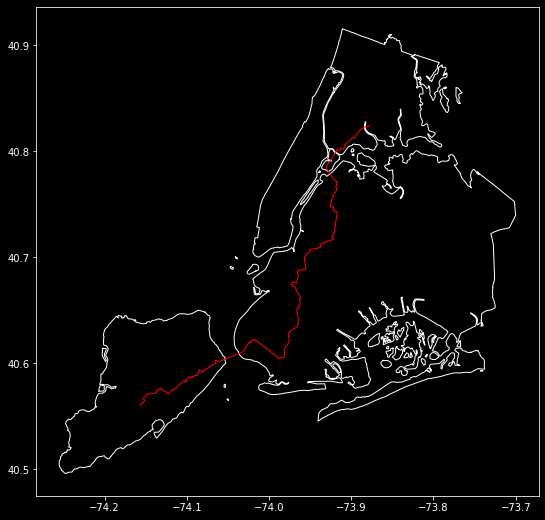

In [17]:
points = np.array(streetsShapeRecs[0].shape.points)
parts = streetsShapeRecs[0].shape.parts
parts.append(points.shape[0])
plt.style.use('dark_background')
plt.figure(figsize=(9,9))
for i in range(len(parts)-1):
    spos = parts[i]
    epos = parts[i+1]
    polygon = points[spos:epos,:]
    plt.plot(polygon[:,0],polygon[:,1],c='w',linewidth=1);
plt.plot(route[:,0],route[:,1],c='r',linewidth=1);

In [18]:
X = {}
X['O'] = O
X['N'] = N
X['edges'] = newedges
X['nodes'] = newnodes + connodes 
X['nodenames'] = newnodenames + connodenames
X['edgedatabase'] = edgedatabase
X['G'] = G
X['Nlist'] = Nlist
X['streets'] = streets
pickle.dump(X,open('../data/graphs/nyc.p',"wb"))